<a href="https://colab.research.google.com/github/vidakpop/chess-image-detection/blob/main/chess_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:
!pip install patool

In [ ]:
import patoolib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks



/content/drive/MyDrive/Colab Notebooks


In [ ]:
%cd dataset

/content/drive/MyDrive/Colab Notebooks/dataset


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset'
path_img = list(glob.glob(path+'/**/*.jpg'))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

File_Path         Labels
0  /content/drive/MyDrive/Colab Notebooks/dataset...  knight-resize
1  /content/drive/MyDrive/Colab Notebooks/dataset...   pawn_resized
2  /content/drive/MyDrive/Colab Notebooks/dataset...    Rook-resize
3  /content/drive/MyDrive/Colab Notebooks/dataset...  knight-resize
4  /content/drive/MyDrive/Colab Notebooks/dataset...   pawn_resized

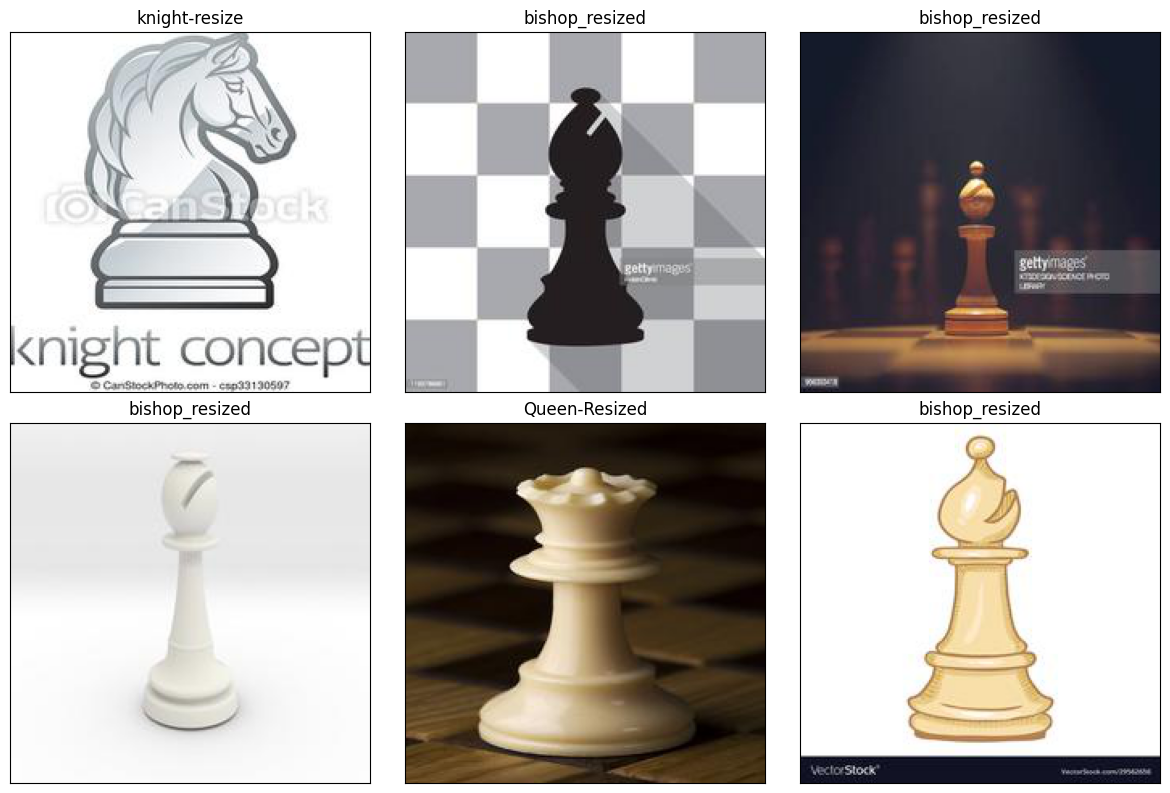

In [ ]:
#visualization
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

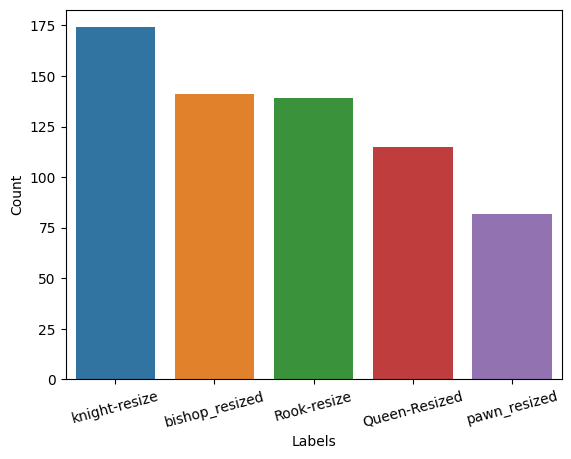

In [ ]:
#visualising counts with  labels using a bar graph
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=15);



In [ ]:
#splitting train and test
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)


In [ ]:
def func(pre,name_model,size):
    print('#####~Model => {} '.format(name_model))
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)

    pre_model = name_model(input_shape=(size,size, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]

    history = model.fit(train_gen,validation_data=valid_gen,epochs=100,callbacks=my_callbacks,verbose=0);
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()

    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))

    return results

#####~Model => <function EfficientNetB7 at 0x7f89c6e4b130> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
258076736/258076736 [==============================] - 2s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


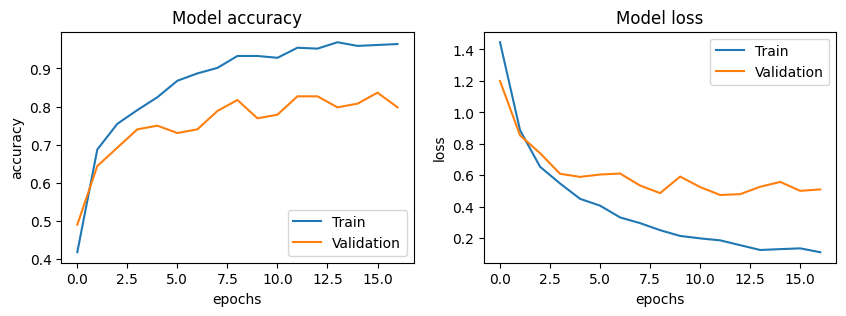

5/5 [==============================] - 22s 3s/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.74      0.59      0.65        29
   Rook-resize       0.85      0.81      0.83        27
bishop_resized       0.56      0.64      0.60        28
 knight-resize       0.82      0.89      0.85        36
  pawn_resized       0.73      0.73      0.73        11

      accuracy                           0.74       131
     macro avg       0.74      0.73      0.73       131
  weighted avg       0.74      0.74      0.74       131

 Display 6 pictures of the dataset with their labels 


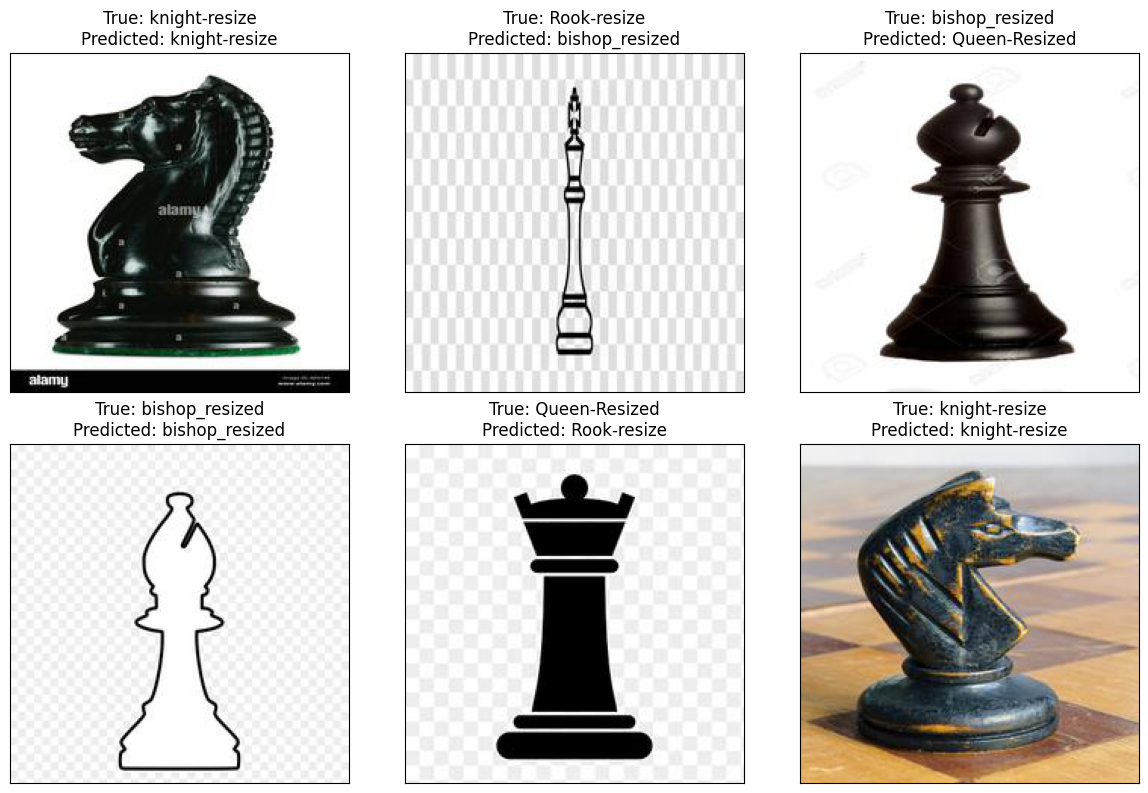

              Results 
    Test Loss:  0.72821  
Test Accuracy:  74.05%  


In [18]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
result_EfficientNetB7 = func(preprocess_input,EfficientNetB7,100)

#####~Model => <function ResNet152 at 0x7f89c6e7ea70> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
234698864/234698864 [==============================] - 5s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


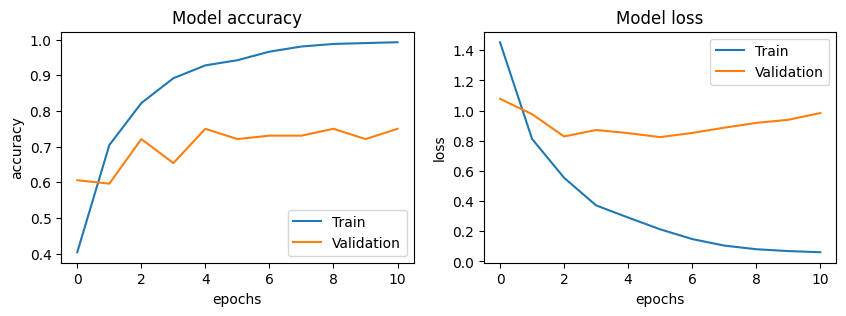

5/5 [==============================] - 19s 3s/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.66      0.66      0.66        29
   Rook-resize       0.77      0.63      0.69        27
bishop_resized       0.62      0.71      0.67        28
 knight-resize       0.82      0.92      0.87        36
  pawn_resized       0.50      0.36      0.42        11

      accuracy                           0.71       131
     macro avg       0.68      0.66      0.66       131
  weighted avg       0.71      0.71      0.70       131

 Display 6 pictures of the dataset with their labels 


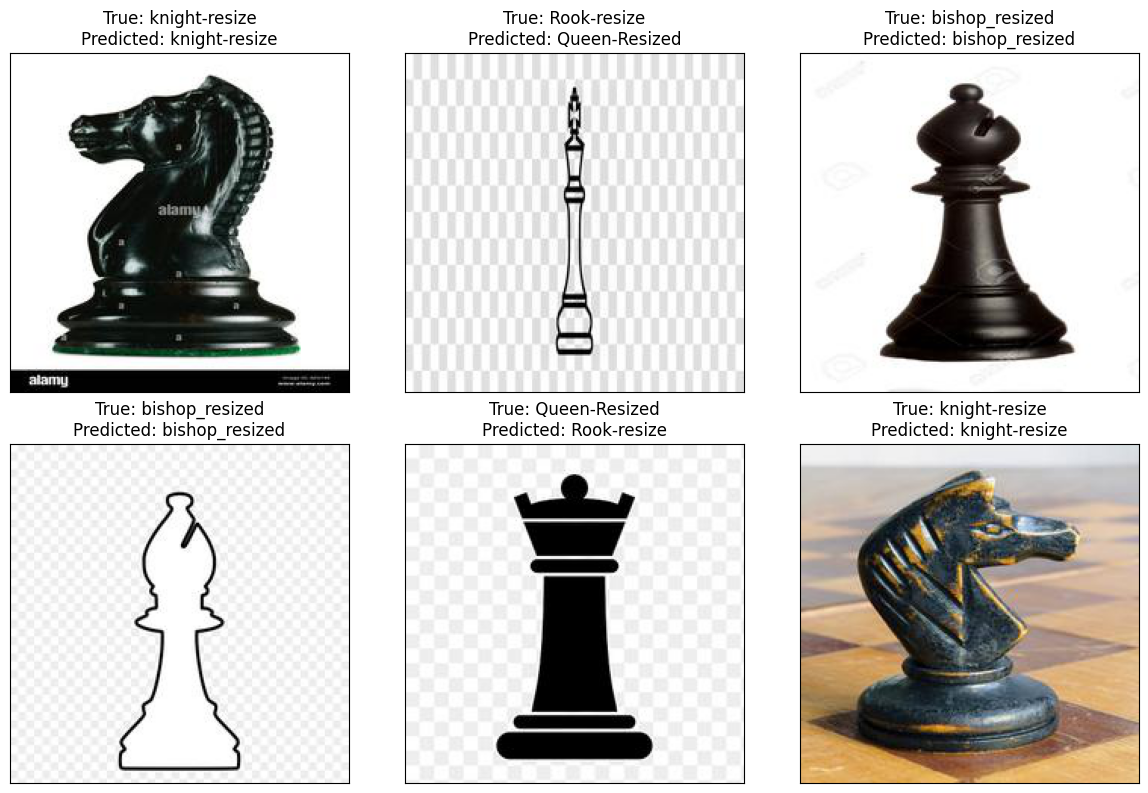

              Results 
    Test Loss:  0.94178  
Test Accuracy:  70.99%  


In [17]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet152 = func(preprocess_input,ResNet152,100)

#####~Model => <function MobileNetV2 at 0x7f89c6e7cc10> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.


              Plotting Accuracy, val_accuracy, loss, val_loss 


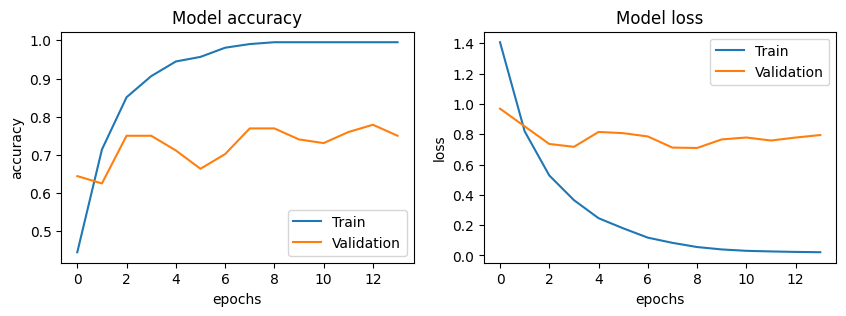

5/5 [==============================] - 3s 367ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.65      0.45      0.53        29
   Rook-resize       0.81      0.78      0.79        27
bishop_resized       0.64      0.75      0.69        28
 knight-resize       0.80      0.89      0.84        36
  pawn_resized       0.67      0.73      0.70        11

      accuracy                           0.73       131
     macro avg       0.71      0.72      0.71       131
  weighted avg       0.72      0.73      0.72       131

 Display 6 pictures of the dataset with their labels 


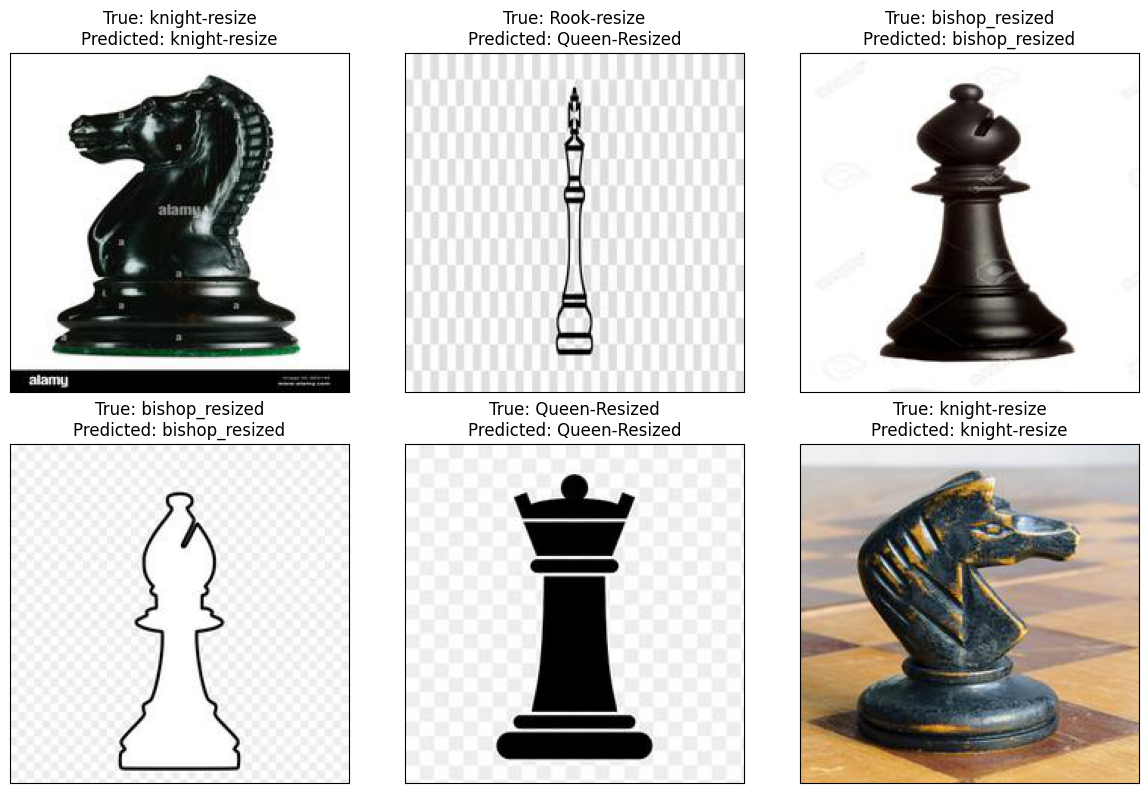

              Results 
    Test Loss:  1.08261  
Test Accuracy:  72.52%  


In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
result_MobileNetV2 = func(preprocess_input,MobileNetV2,100)



#####~Model => <function ResNet101V2 at 0x7f89c6e7f910> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
171317808/171317808 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


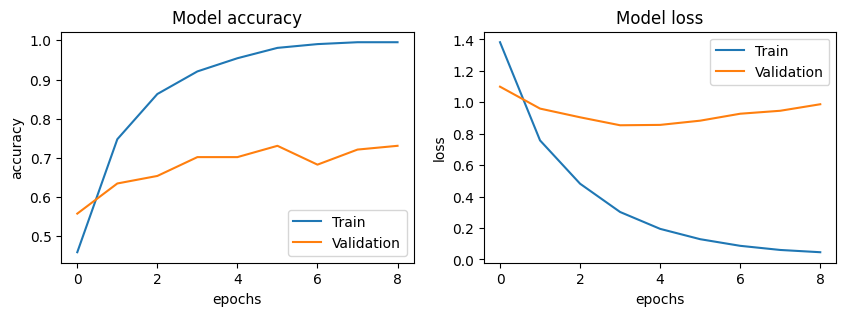

5/5 [==============================] - 12s 2s/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.80      0.41      0.55        29
   Rook-resize       0.68      0.78      0.72        27
bishop_resized       0.59      0.61      0.60        28
 knight-resize       0.75      0.92      0.83        36
  pawn_resized       0.33      0.36      0.35        11

      accuracy                           0.66       131
     macro avg       0.63      0.62      0.61       131
  weighted avg       0.68      0.66      0.65       131

 Display 6 pictures of the dataset with their labels 


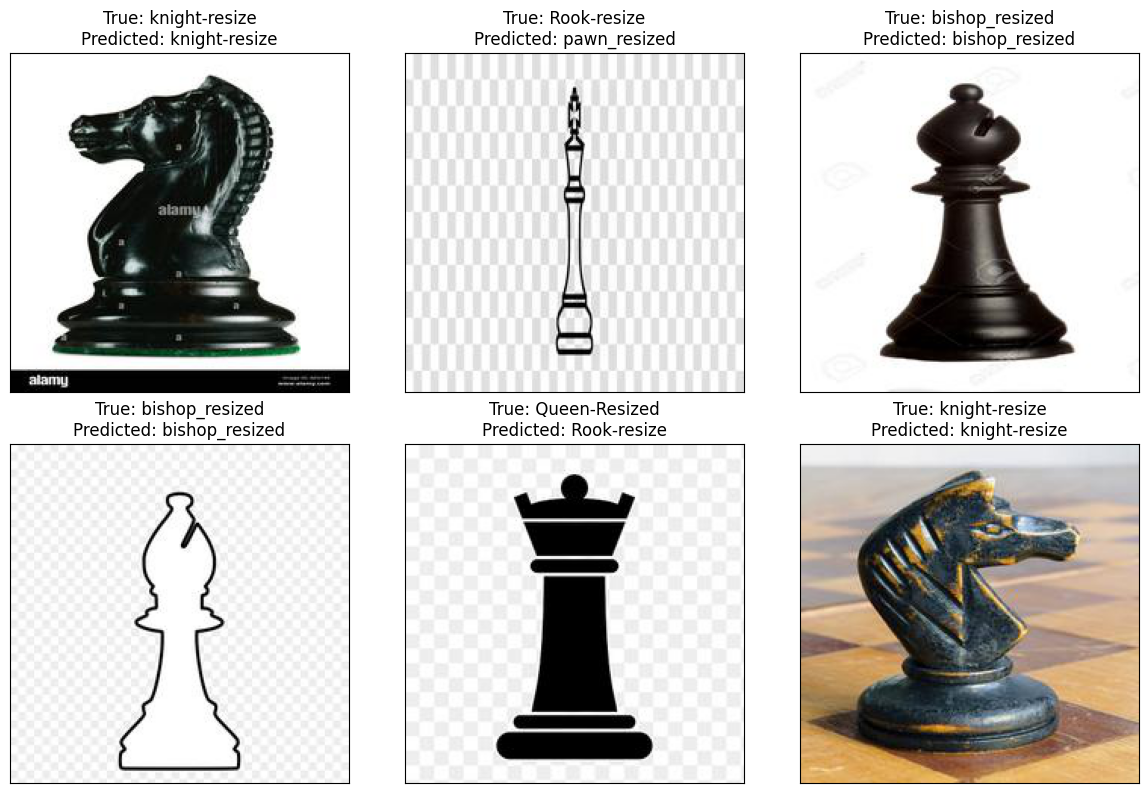

              Results 
    Test Loss:  1.11058  
Test Accuracy:  66.41%  


In [ ]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
result_ResNet101V2 = func(preprocess_input,ResNet101V2,100)


#####~Model => <function InceptionV3 at 0x7f89c6e7c550> 
Found 416 validated image filenames belonging to 5 classes.
Found 104 validated image filenames belonging to 5 classes.
Found 131 validated image filenames belonging to 5 classes.
              Plotting Accuracy, val_accuracy, loss, val_loss 


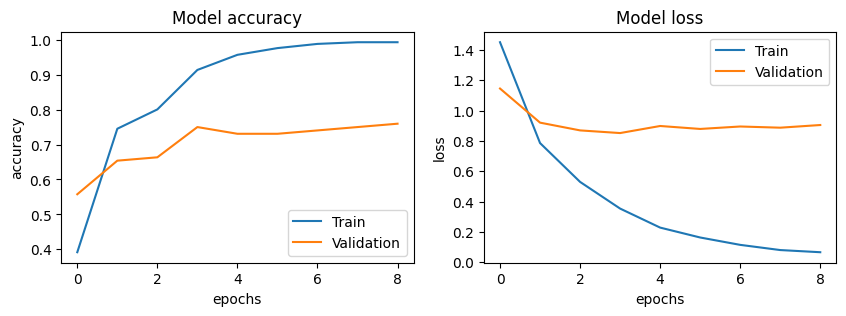

5/5 [==============================] - 4s 357ms/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.69      0.69      0.69        29
   Rook-resize       0.79      0.70      0.75        27
bishop_resized       0.65      0.54      0.59        28
 knight-resize       0.81      0.83      0.82        36
  pawn_resized       0.50      0.82      0.62        11

      accuracy                           0.71       131
     macro avg       0.69      0.72      0.69       131
  weighted avg       0.72      0.71      0.71       131

 Display 6 pictures of the dataset with their labels 


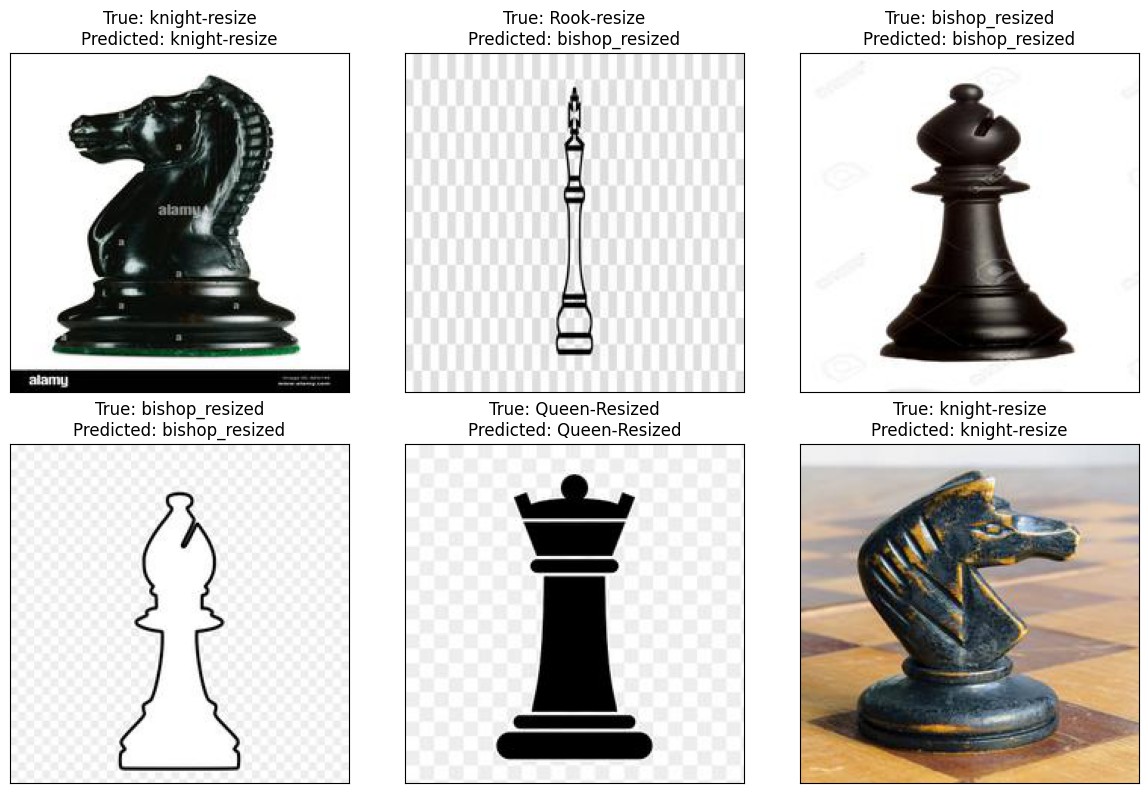

              Results 
    Test Loss:  1.08090  
Test Accuracy:  70.99%  


In [24]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
result_InceptionV3 = func(preprocess_input,InceptionV3,100)

In [26]:
output = pd.DataFrame({'Model':['InceptionV3','EfficientNetB7','ResNet152 ','MobileNetV2 ','ResNet101V2'],
                      'Accuracy':[result_InceptionV3[1],result_EfficientNetB7[1],result_ResNet152[1],result_MobileNetV2[1],result_ResNet101V2[1]]})

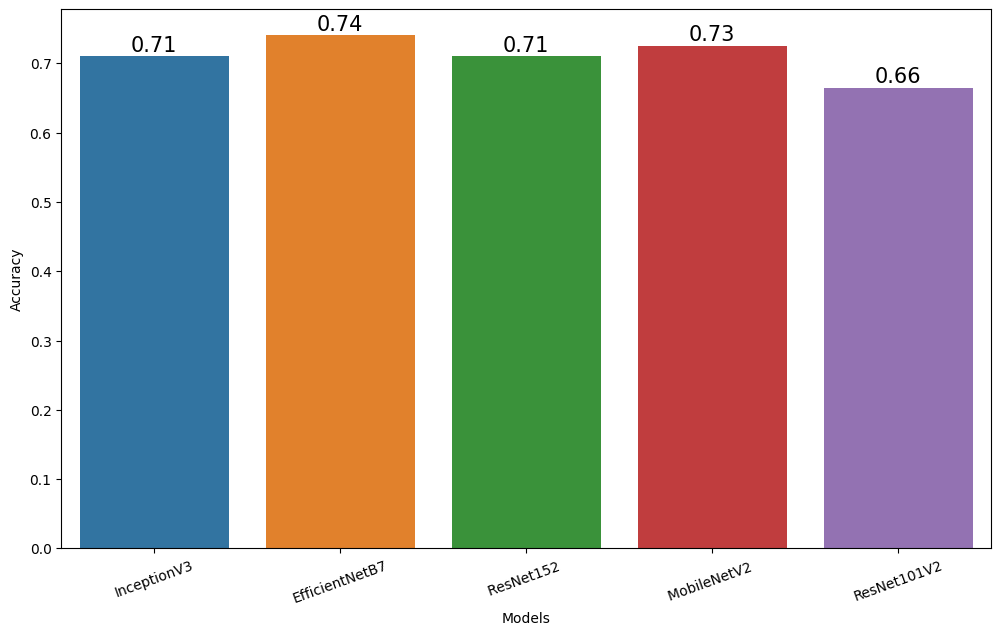

In [27]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=20);